##### <br><font size=6>Machine Learning Final Project group number 8</font><br>

### submitters: Tuval Kay id: 311402531 & Noa Adler id: 312122864.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore, normaltest, norm
from scipy import interp
from tqdm.notebook import tqdm
from functools import reduce
import os
import time
from sklearn import preprocessing, ensemble, tree, metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline



In [2]:
X = pd.read_csv("feature_data.csv",index_col=0)
y = pd.read_csv("label_data.csv",index_col=0)

In [3]:
X_backup = X.copy() # we want to back out data in case we will change it and some thing will go wrong.


## Exploralization 

#### first we will take a look at the data and start to understand it.

In [4]:
print(f"our data has {X.shape[0]} samples and {X.shape[1]} features.")


our data has 89542 samples and 33 features.


In [5]:
X.head()

,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,order_type,...,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,Offline TA/TO,...,0,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0
28536,3.0,2016,October,week_41,2,2,0.0,0,ESP,Online TA,...,0,3.0,0.0,1.0,1,1.0,0.444719,2.343371,True,NaN
21745,NaN,2017,March,week_12,19,1,0.0,0,DEU,Direct,...,4,4.0,0.0,0.0,0,1.0,0.598733,2.498820,True,NaN
17502,153.0,2015,September,week_40,29,2,0.0,0,GBR,Offline TA/TO,...,3,3.0,0.0,0.0,0,1.0,0.335675,12.411559,True,NaN
83295,33.0,2016,January,week_5,25,2,0.0,0,BRA,Corporate,...,0,0.0,15.0,0.0,0,0.0,0.492874,5.743378,True,NaN


#### next step will be to check if there are any missing values, we will look at the sum of the missing values for each feature.

In [6]:
X.isnull().sum()
#we notice that the features "company" & "anon_feat_13" are almost empty, hence we will probobly want to drop them at the preprocessing stage.

time_until_order       12681
order_year                 0
order_month             3434
order_week                 0
order_day_of_month         0
adults                     0
children                   4
babies                     0
country                 4341
order_type                 0
acquisition_channel        0
prev_canceled              0
prev_not_canceled          0
changes                 3477
deposit_type            9006
agent                  12196
company                84480
customer_type           9895
adr                     2983
anon_feat_0             3381
anon_feat_1                0
anon_feat_2                0
anon_feat_3                0
anon_feat_4                0
anon_feat_5             4032
anon_feat_6             4233
anon_feat_7             4248
anon_feat_8                0
anon_feat_9             3731
anon_feat_10            2732
anon_feat_11            4957
anon_feat_12               0
anon_feat_13           83766
dtype: int64

In [7]:
X.dtypes #looking at the features types

time_until_order       float64
order_year               int64
order_month             object
order_week              object
order_day_of_month       int64
adults                   int64
children               float64
babies                   int64
country                 object
order_type              object
acquisition_channel     object
prev_canceled            int64
prev_not_canceled        int64
changes                float64
deposit_type            object
agent                  float64
company                float64
customer_type           object
adr                    float64
anon_feat_0            float64
anon_feat_1              int64
anon_feat_2              int64
anon_feat_3              int64
anon_feat_4              int64
anon_feat_5            float64
anon_feat_6            float64
anon_feat_7            float64
anon_feat_8              int64
anon_feat_9            float64
anon_feat_10           float64
anon_feat_11           float64
anon_feat_12              bool
anon_fea

#### we want to check how each feature is distributed 

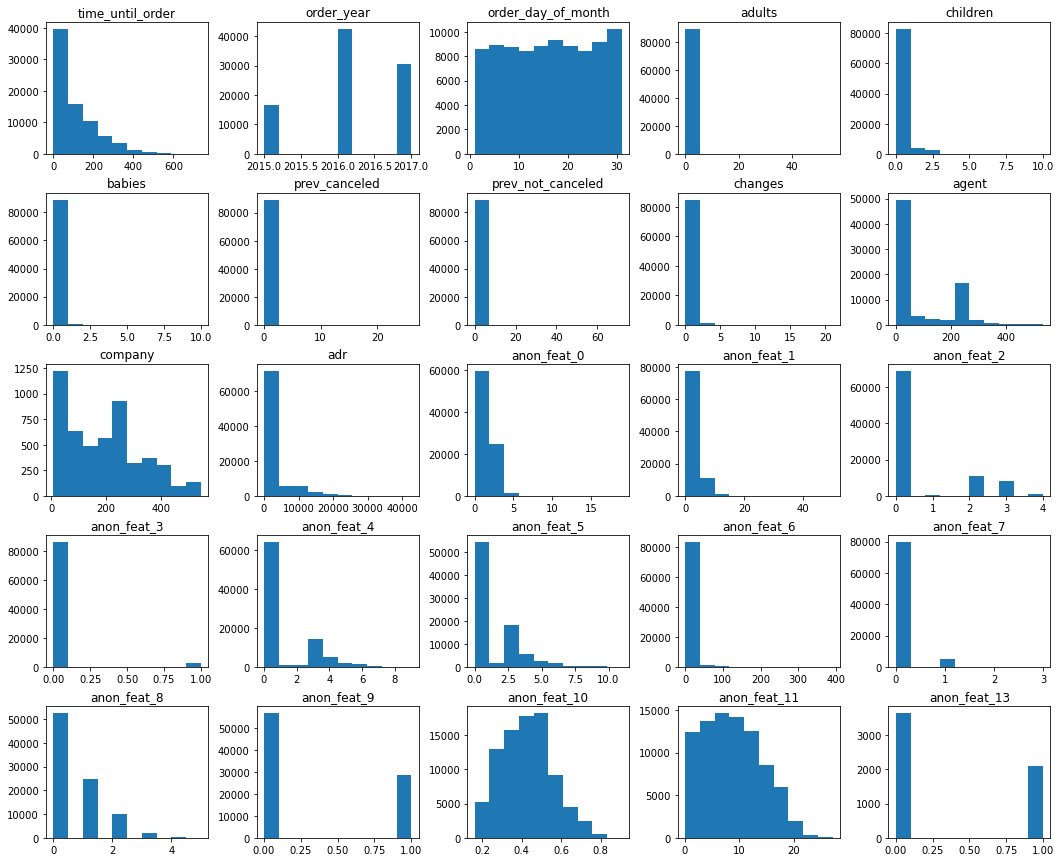

In [8]:
"""note: on some computers the hist func returned an err, because it tried to make a hist on
non-numeric features, hence befor preforming we will convert the data that we send
to the fuction to be from numeric types only)."""
numeric_data = X.select_dtypes('number')

df_for_hist = numeric_data.hist(figsize=(18,15), grid = False)
 
# we can see that not all the features are randomly distributed,
# some of the models will probobly require that hence we will want to normalize them at the preprocessing stage.



####  we want to check if there is any corelation between the features and may be get a hint which features we should consider droping later.

In [9]:
# correlation between every couple of features.
corr = numeric_data.corr()
 
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,agent,company,adr,anon_feat_0,anon_feat_1,anon_feat_2,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_13
time_until_order,1.00,0.04,0.00,0.12,-0.04,-0.02,0.08,-0.07,0.00,-0.07,0.16,0.01,0.09,0.17,-0.00,-0.13,-0.10,-0.17,0.17,-0.12,-0.09,-0.08,-0.49,0.96,0.29
order_year,0.04,1.00,0.00,0.03,0.05,-0.01,-0.12,0.03,0.03,0.06,0.26,0.02,0.02,0.03,0.07,0.01,0.09,0.04,-0.06,-0.01,0.11,-0.03,-0.04,0.05,0.01
order_day_of_month,0.00,0.00,1.00,-0.00,0.02,0.00,-0.02,0.00,0.01,-0.00,0.05,0.04,-0.02,-0.03,-0.01,-0.01,0.02,0.01,0.02,0.01,0.00,0.00,-0.01,0.01,0.01
adults,0.12,0.03,-0.00,1.00,0.03,0.02,-0.01,-0.11,-0.05,-0.04,0.20,0.13,0.10,0.09,0.02,-0.15,0.22,0.15,-0.01,0.02,0.13,0.01,-0.12,0.15,0.05
children,-0.04,0.05,0.02,0.03,1.00,0.03,-0.02,-0.02,0.05,0.04,0.03,0.15,0.05,0.04,-0.05,-0.03,0.38,0.33,-0.03,0.06,0.08,0.05,-0.00,-0.03,0.03
babies,-0.02,-0.01,0.00,0.02,0.03,1.00,-0.01,-0.01,0.08,0.04,0.01,0.02,0.02,0.02,0.00,-0.01,0.04,0.04,-0.01,0.03,0.10,0.04,0.01,-0.02,-0.03
prev_canceled,0.08,-0.12,-0.02,-0.01,-0.02,-0.01,1.00,0.15,-0.03,-0.01,-0.19,-0.03,-0.02,-0.02,-0.00,0.08,-0.05,-0.06,0.01,-0.02,-0.05,0.01,-0.03,0.08,0.11
prev_not_canceled,-0.07,0.03,0.00,-0.11,-0.02,-0.01,0.15,1.00,0.01,0.02,-0.21,-0.04,-0.04,-0.05,-0.04,0.42,-0.02,0.00,-0.01,0.04,0.04,0.01,0.08,-0.10,-0.07
changes,0.00,0.03,0.01,-0.05,0.05,0.08,-0.03,0.01,1.00,0.07,0.13,0.04,0.06,0.10,0.03,0.01,0.05,0.10,-0.01,0.06,0.05,0.07,-0.01,0.01,-0.14
agent,-0.07,0.06,-0.00,-0.04,0.04,0.04,-0.01,0.02,0.07,1.00,0.35,0.02,0.14,0.18,-0.05,0.03,0.21,0.24,-0.06,0.18,0.03,0.79,0.05,-0.07,-0.09


In [10]:
""" we notice high correlation between the features ('agent' & 'anon_feature_9'),
('time_until_order' & 'anon_feat_11'),('anon_feat_4' & 'anon_feat_5')."""

numeric_data['y']= y
print(f"lets take a closer look at the corr values between our features and label \n {X.corrwith(numeric_data.y).sort_values(ascending=False)}")


lets take a closer look at the corr values between our features and label 
 anon_feat_13          1.000000
anon_feat_11          0.313919
time_until_order      0.294502
prev_canceled         0.109633
anon_feat_6           0.058219
adults                0.058103
anon_feat_1           0.026997
order_year            0.014949
children              0.005691
anon_feat_0          -0.000038
anon_feat_12         -0.004417
order_day_of_month   -0.006737
company              -0.012482
anon_feat_2          -0.016972
babies               -0.032331
prev_not_canceled    -0.060068
anon_feat_4          -0.060772
adr                  -0.070436
agent                -0.081911
anon_feat_3          -0.085612
anon_feat_9          -0.136527
changes              -0.144559
anon_feat_5          -0.176803
anon_feat_7          -0.197533
anon_feat_10         -0.204077
anon_feat_8          -0.233985
dtype: float64


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##### we can see a significate cor between the label 'y' & the anon_feat_13.

#### before the preprocessing stage we want to devide our data into train & test data sets, so we can train our models befor the actual data_test.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True,random_state=42) # random_state=42 will insure we produce the same results across a different run

## Preprocessing 

#### to make the process easier we made functions that the data would be sent to.

In [12]:
def pre_processing(x):
    
    #making sure there are no duplicates in the data
    x = x.drop_duplicates() 

    ###
    # we created a date feature that combined the YYMMDD.
    
    x['order_week'] = x['order_week'].map(lambda x: x.lstrip('week_'))

    x['order_date'] = pd.to_datetime(x.order_week.astype(str)+
                           x.order_year.astype(str).add('-1') ,format='%V%G-%u')

    x['order_date'] = x['order_date'].astype(str).str[:8] + x['order_day_of_month'].astype(str)
    
    #replacing NaN values for the order_month column & making the month and weel numeric values
    x['order_month_2'] = x['order_date'].astype(str).str[5:7]
    x['order_month'] = x['order_month_2'].astype(int)
    x['order_week'] = x['order_week'].astype(int)
    
    """we notices that there are a few thousand missing months,
       so we calcoulated the correct month for each sample,
       throuh the week of the year that it has been orderd."""
    ###
    
    
    ###
    """ number of missing companys,anon_feat_13 labels are: 84480,83766 out of 89542 hence we decide to drop the feature.
    as we notice on the exploration part the 'anon_featue_13' has a strong correlation to our label,
    we took it into considaration but still decided that to drop it."""
    
    x.drop(columns=['company','anon_feat_13'], inplace=True)
    ###

    
    ### convert bool feature into numeric values
    result = x['anon_feat_12'].astype(int)
    x['anon_feat_12'] = result
    ###
    
 
    ###
    """taking care of NaN valures, we handeled each feature diffrently some we replaced we the mean others with the medians,
    and for the object typs we decided to fill with the nearest neighbors"""
    
    x['time_until_order'].fillna(x['time_until_order'].median(), inplace = True)
    x['children'].fillna(value= 0, inplace = True) 
    x['changes'].fillna(x['changes'].median(), inplace = True)
    x['adr'].fillna(x['adr'].median(), inplace = True)
    x['agent'].fillna(x['agent'].mean(), inplace = True)
    x['anon_feat_0'].fillna(x['anon_feat_0'].mean(), inplace = True)
    x['anon_feat_1'].fillna(x['anon_feat_1'].mean(), inplace = True)
    x['anon_feat_2'].fillna(x['anon_feat_2'].mean(), inplace = True)
    x['anon_feat_3'].fillna(x['anon_feat_3'].mean(), inplace = True)
    x['anon_feat_4'].fillna(x['anon_feat_4'].mean(), inplace = True)
    x['anon_feat_5'].fillna(x['anon_feat_5'].mean(), inplace = True)
    x['anon_feat_6'].fillna(x['anon_feat_6'].mean(), inplace = True)
    x['anon_feat_7'].fillna(x['anon_feat_7'].mean(), inplace = True)
    x['anon_feat_8'].fillna(x['anon_feat_8'].mean(), inplace = True)
    x['anon_feat_9'].fillna(x['anon_feat_9'].mean(), inplace = True)
    x['anon_feat_10'].fillna(x['anon_feat_10'].mean(), inplace = True)
    x['anon_feat_11'].fillna(x['anon_feat_11'].mean(), inplace = True)
     
    x["country"] = x["country"].interpolate(method='pad')
    x["deposit_type"] = x["deposit_type"].interpolate(method='pad')
    x["customer_type"] = x["customer_type"].interpolate(method='pad')
    x["order_date"] = x["order_date"].interpolate(method='pad')
    x["acquisition_channel"] = x["acquisition_channel"].interpolate(method='pad')
    x["order_type"] = x["order_type"].interpolate(method='pad')
    ###
    
    ###
    """next we decided to make dummie variables for the object types and give them a numeric meaning.
    
    note: some computers made a err when calling the preprocessing func,
    saying the transfrom on some of the features made them of mix type float & int,
    so just in case we made sure it is of type int."""
    
    le = LabelEncoder()
    le.fit(x['country'])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    x['country'] = le.transform(x['country'])
    x['country'] = x['country'].astype('int')
    
    le.fit(x['deposit_type'])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    x['deposit_type'] = le.transform(x['deposit_type'])
    
    le.fit(x['customer_type'])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    x['customer_type'] = le.transform(x['customer_type'])
    x['customer_type'] = x['customer_type'].astype('int')
    
    le.fit(x['order_type'])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    x['order_type'] = le.transform(x['order_type'])
    x['order_type'] =x['order_type'].astype('int')
    
    le.fit(x['acquisition_channel'])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    x['acquisition_channel'] = le.transform(x['acquisition_channel'])
    x['acquisition_channel'] = x['acquisition_channel'].astype('int')
    ###
    
    ###
    #we learned that date features are problomatic.
    
    x.drop(columns=['order_date'], inplace=True)
    ###
    
    #make a data frame of numeric data only.
    x_numeric = x.select_dtypes(include='number')
    # boxplot with outliers
    boxplot = x_numeric.boxplot(rot=45, figsize = (12,6)).set_title('data with numeric outliers')
    
    
    return  x_numeric

###########################################################################################

""" we wanted to get rid of the outlayers without losing a significante amount of our data,
hence we decided to replace the outliers values with the zscore value of +-Var=3 values"""

def Z_Score_replace_outliers(data, ax= None):
    data_copy = data.copy()
    z_score_data = data_copy[(data_copy.apply(zscore) < 3).all(axis=1)]
    
    features = z_score_data.columns.tolist()

    max_data = []
    max_data_1 = []
    min_data = []
    min_data_1 = []
    for i in range(len(features)):
        max_value = data_copy[features[i]].max()
        max_data.append(max_value)
        min_value = data_copy[features[i]].min()
        min_data.append(min_value)
        
    
    for i in range(len(features)):
        max_value = z_score_data[features[i]].max()
        max_data_1.append(max_value)
        min_value = z_score_data[features[i]].min()
        min_data_1.append(min_value)
        
        
    for i in range(len(features)):
        num = np.array(data_copy[features[i]].values.tolist())
        data_copy[features[i]] = np.where(num > max_data_1[i] , max_data_1[i], num).tolist()
        
    for i in range(len(features)):
        num = np.array(data_copy[features[i]].values.tolist())
        data_copy[features[i]] = np.where(num < min_data_1[i] , min_data_1[i], num).tolist()
  
    z_score_data.boxplot(rot=45, figsize = (15,6)).set_title('data after droping outliers using zscore')
    return data_copy


#scaling using z-score - Feature Normalization

def Z_Score_Normalization(data, ax= None): #(Mu=0, Var=1)
    data_fixed_zscore = data.copy()
    for column in data_fixed_zscore:
        if column == "babies":
            continue
        elif column == "anon_feat_3":
            continue
        else:
            data_fixed_zscore[column] = (data[column] - data[column].mean()) / data[column].std()
            
    data_fixed_zscore.boxplot(rot=45, figsize = (15,6)).set_title('boxplot: Z_Score_Normalization Mu=0, Var=1')
    return data_fixed_zscore 

###########################################################################################

# fumc that makes a histogram with a density lyne to help us see if the data is normally dist

def hist_with_den_line(data):
    
    _, bins, _ = plt.hist(data, 15, density=1, alpha=1)
    mu, sigma = norm.fit(data)
    best_fit_line = norm.pdf(bins, mu, sigma)
    
    plt.plot(bins, best_fit_line, linestyle = 'dashed', color = 'black')
    plt.title("data with best fit density line")
    plt.show()
    
    
    
    
###########################################################################################

# PCA func

def pca(data, num_components = None):
    ######## pca without define num to drop##########
    if num_components is None:
        num_components = data.shape[1]
    
    data_copy = data.copy()
    pca = PCA(n_components = num_components )
    pca.fit(data_copy)
    X_train_pca= pca.transform(data_copy)
    
    f, axes = plt.subplots(1,2,figsize = (15,6))
    f.suptitle('PCA')
    axes[0].set_title('explained variance: ')
    axes[1].set_title('explained variance ratio cumsum: ')
    sns.lineplot(data=pca.explained_variance_ratio_ ,ax=axes[0])
    sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_) ,ax=axes[1])

    print(f"explained variance ratio sum for {num_components} features is {pca.explained_variance_ratio_.sum()}")
    return X_train_pca

###########################################################################################

# use RandomForestClassification for feature importance & slection.

def Random_Forest_Classification_Feature_Importance(X_train, y_train):
    # get importance 
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    # get importance
    feature_importance = rf.feature_importances_
    # summarize feature importance
    for i,v in enumerate(feature_importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    
    # plot feature importance
    plt.rcParams["figure.figsize"] = (12,8)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(X_te.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel(RandomForestClassifier())
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

    
   
    

### handeling out liaers
#### we wanted to get rid of the outlayers without losing a significante amount of our data,  hence we decided to replace the outliers values with the a zscore function that replaced all values that were larger or smaller than value of +-Var=3 values.

### The importance of data normalization.
#### most of our features were not normalized, this can influence result, short explanation for the reason not all features have the same matrices, lets take for example the features children & order_year lets say most families have 0-5 children and the years of the reservations were 2015-2017 it is very hard to compare them without normalize, hence we normalized the entire data.


### handeling NaN values
####  taking care of NaN valures, we handeled each feature diffrently for the numeric type we replaced NaN with the mean or the median.   for object typs we decided to fill with the nearest neighbors.    we handled them this way because we wanted the NaN values to spread across the entire data not maniplating the results,for the numeric type its very asume logicluy that the mean and median will be the best estimators.  for the object types its a bit more complicated and we will try to explain using an example lets say we have 3 contries one of them with 70% of the data belongs to and the others are 15% each lets say we have 100 samples with country when we filled with the nearst neghibor we could make sure that in a high probabaility the divided countries given to the samples will look close to our original data 70+- will go to the first and +-15 to the others.


### Dimensions 
#### our data had 31 features meaning 31 dimensions.   the problem with large dimensions is caled the "dimensionality curse" the more dimensions we have the more variance we have between the features. meaning we can fit every sample and suffering from over fitting. it is easier to imagine the explanations imagining 1-D vs 2D vs 3D but more than that it is Impossible to imagine, we will add a figure to help illustrate. 
<img src="http://tm.durusau.net/wp-content/uploads/2016/06/curse-dimensions-460.png" width=600>

#### in order to check if we suffer from the dim curse we valuate the difference between the train and test model using the AUC measure. if the train score is much higher than the tests we can understands that the model "fits too well" to our data and doesn't suceed to do that when the actual valdiation is needed.



#### note 1: we checked to see if there are no NaN values left and that we kept all our samples in the process but we moved the checks befor submition.

#### note 2: we knew that not all of our features came from the normal distribution so first we moved the anomalys and then we normalized the data.



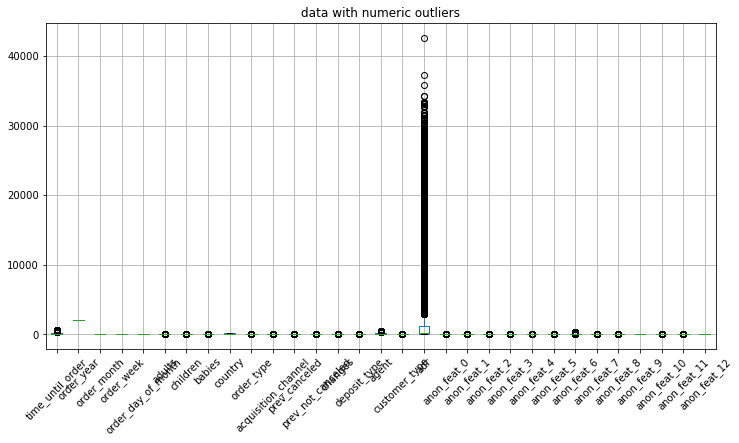

In [13]:
data_train = pre_processing(X_train)

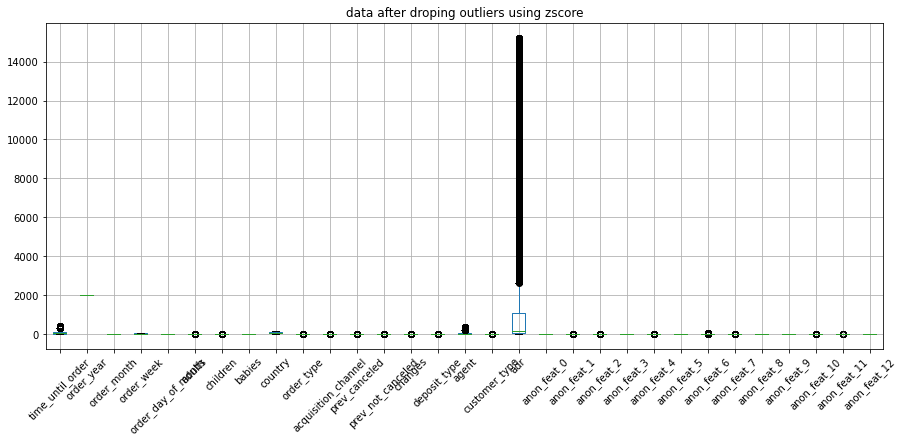

In [14]:
data_train = Z_Score_replace_outliers(data_train)

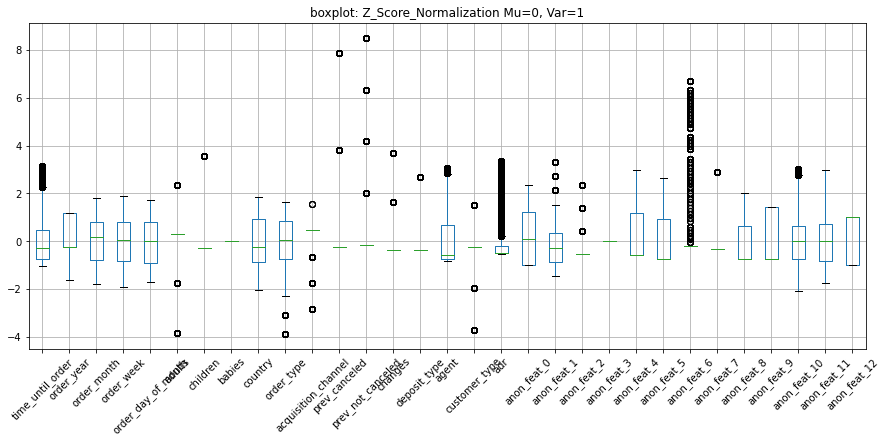

In [15]:
data_train = Z_Score_Normalization(data_train)


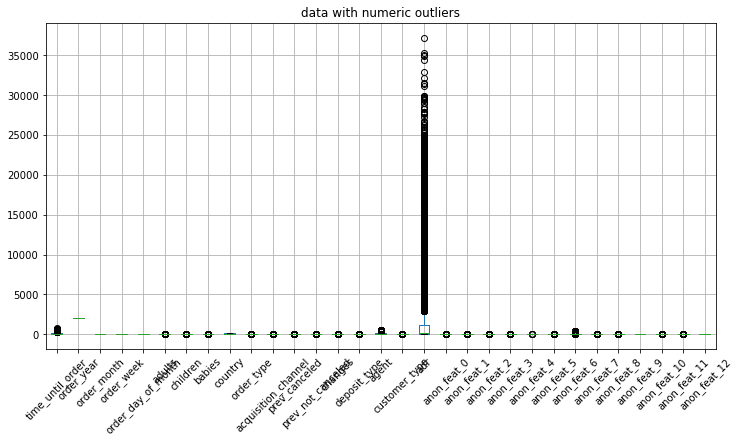

In [17]:
data_valid = pre_processing(X_valid)

In [18]:
data_train.dtypes

time_until_order       float64
order_year             float64
order_month            float64
order_week             float64
order_day_of_month     float64
adults                 float64
children               float64
babies                   int64
country                float64
order_type             float64
acquisition_channel    float64
prev_canceled          float64
prev_not_canceled      float64
changes                float64
deposit_type           float64
agent                  float64
customer_type          float64
adr                    float64
anon_feat_0            float64
anon_feat_1            float64
anon_feat_2            float64
anon_feat_3              int64
anon_feat_4            float64
anon_feat_5            float64
anon_feat_6            float64
anon_feat_7            float64
anon_feat_8            float64
anon_feat_9            float64
anon_feat_10           float64
anon_feat_11           float64
anon_feat_12           float64
dtype: object

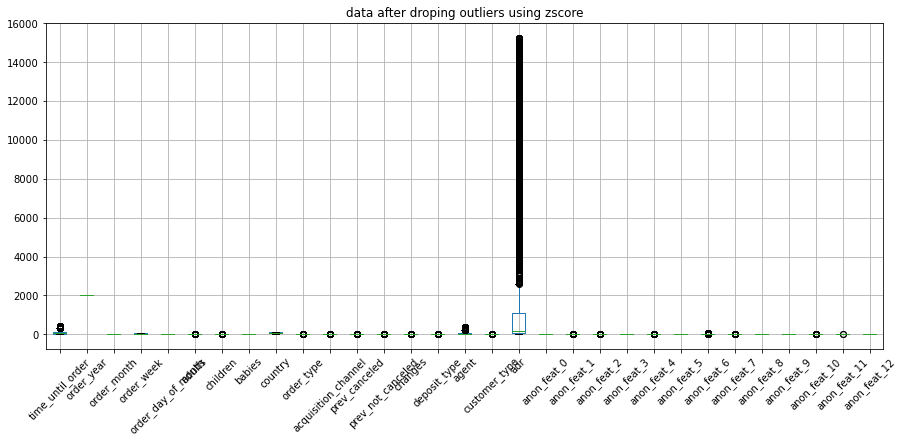

In [19]:
data_valid = Z_Score_replace_outliers(data_valid)

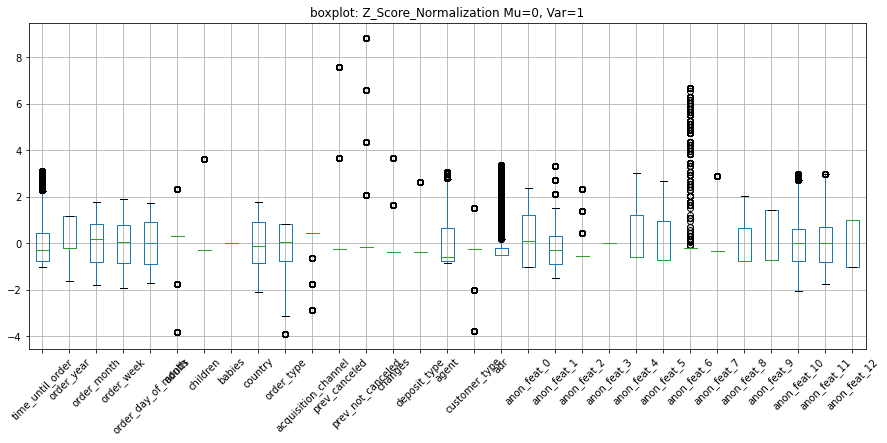

In [20]:
data_valid = Z_Score_Normalization(data_valid)

### Feature selection 

explained variance ratio sum for 31 features is 1.0


array([[-5.25937222e+00,  1.01805647e+00,  2.49353745e-01, ...,
        -2.60355829e-03, -1.47638054e-16,  9.91365346e-18],
       [-2.74740212e+00, -9.53988066e-01,  1.92554332e+00, ...,
        -5.13767239e-02, -4.91215487e-16, -3.32816526e-16],
       [-1.67210060e+00,  2.02533299e-01, -1.40074201e+00, ...,
         1.34558839e-02,  8.15770807e-17, -3.28047852e-17],
       ...,
       [ 1.85294156e-01, -3.67245725e-02, -1.81216352e+00, ...,
         6.07380964e-03,  1.76383275e-16,  1.50741996e-17],
       [ 3.27528950e-01, -1.13615130e+00, -9.11319557e-01, ...,
        -2.68722669e-03,  1.10507377e-16,  2.40391722e-16],
       [-1.16144923e+00, -6.47939461e-01,  2.49182725e+00, ...,
        -2.35548463e-02, -2.16140066e-16,  1.16001117e-16]])

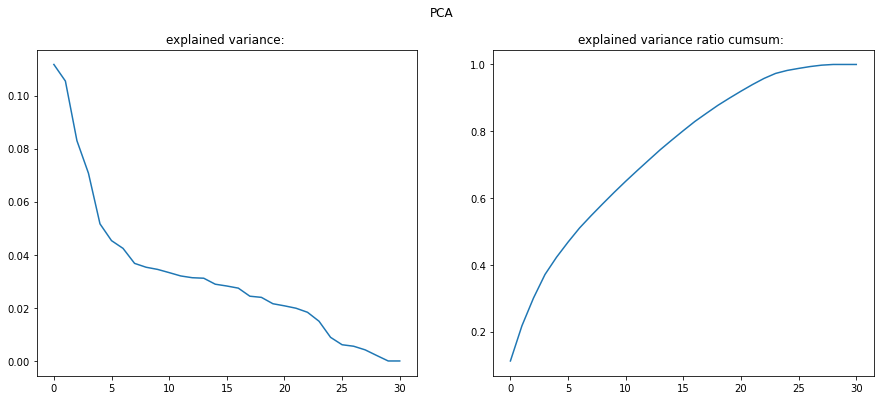

In [22]:
pca(data_train)

explained variance ratio sum for 25 features is 0.982070656633935


array([[-5.25937222,  1.01805647,  0.24935374, ...,  0.34024595,
         0.38594047,  0.19672293],
       [-2.74740212, -0.95398807,  1.92554332, ...,  1.26759634,
         0.39835449,  0.36626055],
       [-1.6721006 ,  0.2025333 , -1.40074201, ..., -0.53898314,
        -0.72190566, -0.29877315],
       ...,
       [ 0.18529416, -0.03672457, -1.81216352, ..., -0.00542716,
        -0.52809616, -0.02329239],
       [ 0.32752895, -1.1361513 , -0.91131956, ...,  0.02157956,
        -0.39376633, -0.05716126],
       [-1.16144923, -0.64793946,  2.49182725, ..., -0.49132744,
        -0.70415977,  0.15701104]])

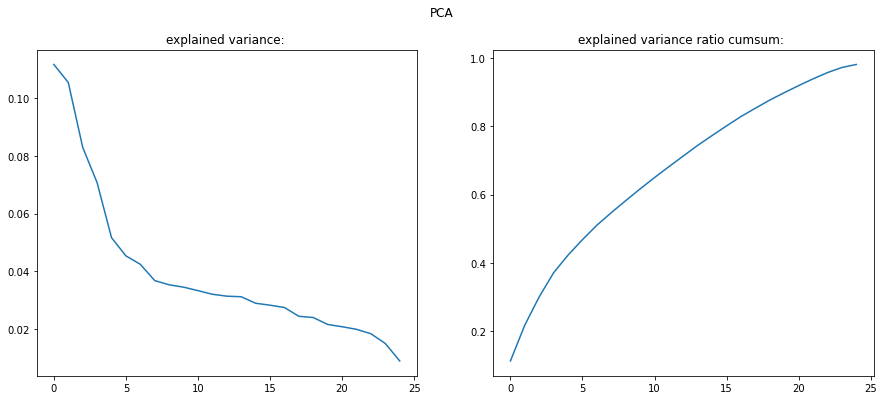

In [23]:
pca(data_train, 25)

/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Feature: 0, Score: 0.07531
Feature: 1, Score: 0.02251
Feature: 2, Score: 0.02698
Feature: 3, Score: 0.04370
Feature: 4, Score: 0.04327
Feature: 5, Score: 0.01134
Feature: 6, Score: 0.00463
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.10374
Feature: 9, Score: 0.04548
Feature: 10, Score: 0.00919
Feature: 11, Score: 0.02948
Feature: 12, Score: 0.00413
Feature: 13, Score: 0.02106
Feature: 14, Score: 0.08294
Feature: 15, Score: 0.05566
Feature: 16, Score: 0.02002
Feature: 17, Score: 0.05840
Feature: 18, Score: 0.01928
Feature: 19, Score: 0.02771
Feature: 20, Score: 0.01091
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.01338
Feature: 23, Score: 0.02502
Feature: 24, Score: 0.00500
Feature: 25, Score: 0.01214
Feature: 26, Score: 0.05850
Feature: 27, Score: 0.01040
Feature: 28, Score: 0.05664
Feature: 29, Score: 0.09348
Feature: 30, Score: 0.00969


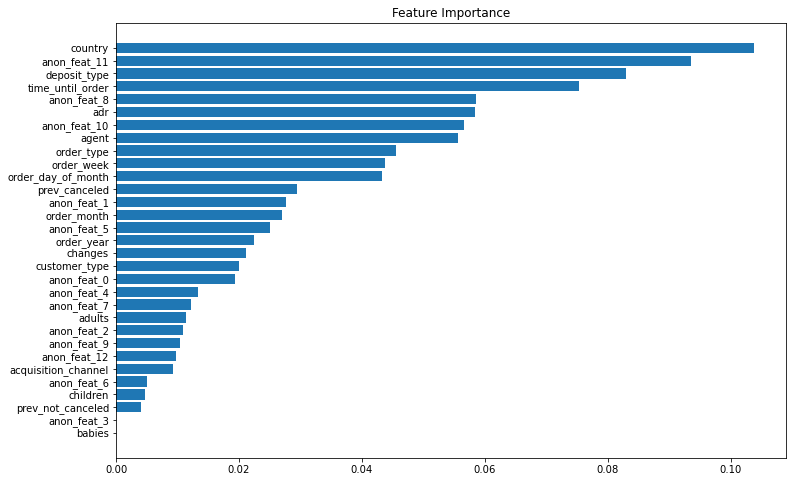

In [24]:
##### make a copy ######
X_tr = data_train.copy()
X_te = data_valid.copy()

Random_Forest_Classification_Feature_Importance(X_tr, y_train)

#### befor moving to the modeling stage we will preprocess the data for the Test prediction that will be done at the end of the proj. 

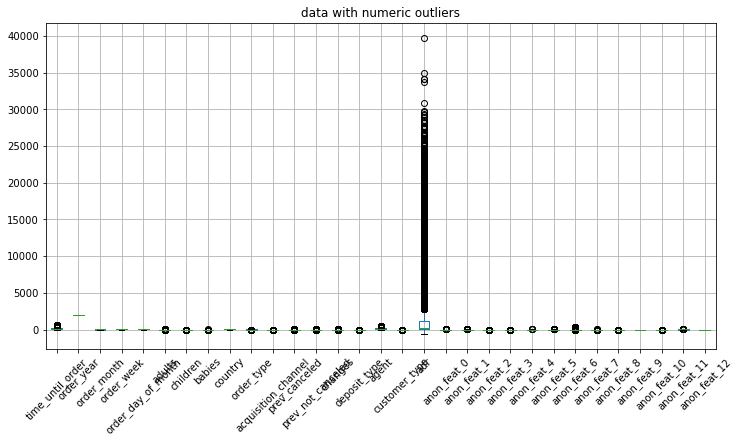

In [25]:
#loading the data test.
X_test = pd.read_csv("feature_data_test.csv",index_col=0)

#preparing the X_test data
X_test = pre_processing(X_test)



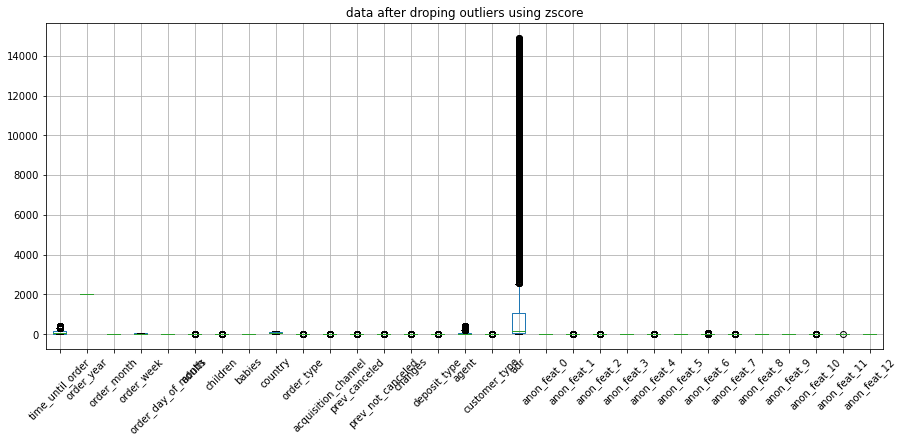

In [26]:
X_test = Z_Score_replace_outliers(X_test)


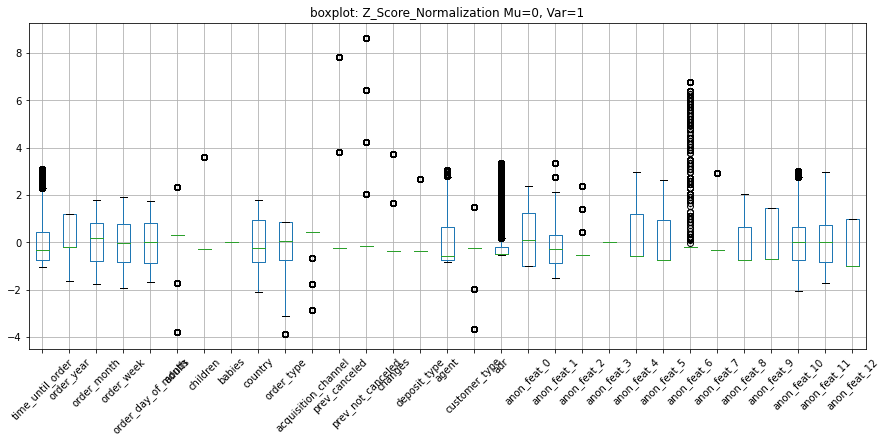

In [27]:
X_test = Z_Score_Normalization(X_test)

## Modeling

### assumbtions:  first we train and test the models without reducing the dimensions, we understand our models may suffer from over fitting because of the "dim_curse" (which we will discuss in deatail in the add notebook).
### then we will compare  the models, and if the best model will suffer from over fitting we will reduce the dim (keeping im mind that not all models suffer from the dim curs, for example RandomForest ).

In [29]:
def KFold_evaluate_model(model_name, clf, X_tr, y_train, X_te, y_valid):         
    # Applying k-fold Method
    kf = KFold(n_splits=3, shuffle=True)
    f, axes = plt.subplots(1,2,figsize = (18,6))
    f.suptitle(model_name + ' KFold ROC_curve plot')
    axes[0].set_title('Train KFold ROC_curve plot')
    axes[1].set_title('Validation KFold ROC_curve plot')
    for train_idx, test_idx in kf.split(X_tr):
        print()
        clf.fit(X_tr.iloc[train_idx], y_train.iloc[train_idx])
        plot_roc_curve(clf, X_tr.iloc[test_idx], y_train.iloc[test_idx], ax=axes[0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    for train_idx, test_idx in kf.split(X_te):
        print()
        clf.fit(X_te.iloc[train_idx],y_valid.iloc[train_idx])
        plot_roc_curve(clf, X_te.iloc[test_idx], y_valid.iloc[test_idx], ax=axes[1])
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    plt.show()

#############################################################################################
    
def plot_conf_mat(model, X_tr,y_train, X_te, y_valid):
   
    #Generate predictions with the model using our X value
    y_pred = model.predict(X_te)
    
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_valid, y_pred)
    
    group_names = ["True_Neg","False_Pos","False_Neg","True_Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### GridSearchCV finding the best parameters

#### GridSearchCV for MLP_Classifier

prams = {'activation' : ["logistic", "relu"], #
                      'hidden_layer_sizes' : [(100,), # 1 large hidden layer
                                             (50, 50), # 2 medium size layers
                                             (10, 10, 10, 10, 10)], # multiple small sized layers
                      'batch_size' : [15, 50],
                      'learning_rate_init' : [0.1, 0.01], #In some of the runs we saw that the network got stuck on a local min, for this reason we enlearge the defualt momentum
                      'max_iter' : [500]} 
                     
ann_GS = GridSearchCV(MLPClassifier(), prams, cv=3, scoring='roc_auc')

ann_GS.fit(X_tr, y_train)
print ('Neural Network chosen parameters (recieved best AUC): {}'.format(ann_GS.best_params_))
print ("Neural Network AUC score with the chosen parameters: ", ann_GS.best_score_)

best_parameters = {'activation': 'logistic',
                   'batch_size': 15,
                   'hidden_layer_sizes': (50, 50),
                   'learning_rate_init': 0.01,
                   'max_iter': 500}
<img style="float: center;" src="https://numenta.com/wp-content/uploads/2020/10/AdobeStock_203293749-1024x465.jpg" width=400>

#### GridSearchCV for the RandomForestClassifier. 
#Create the parameter grid based

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#Fit the grid search to the data
grid_search.fit(X_tr, y_train)
print(grid_search.best_params_)

best_param = {'bootstrap': True,
              'max_depth': 100,
              'max_features': 3,
              'min_samples_leaf': 3,
              'min_samples_split': 8,
              'n_estimators': 1000}
<img src="https://gaussian37.github.io/assets/img/ml/concept/random-forest/Random_Forest.png" width=400>




  0%|          | 0/4 [00:00<?, ?it/s]

/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
No handles with labels found to put in legend.
/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


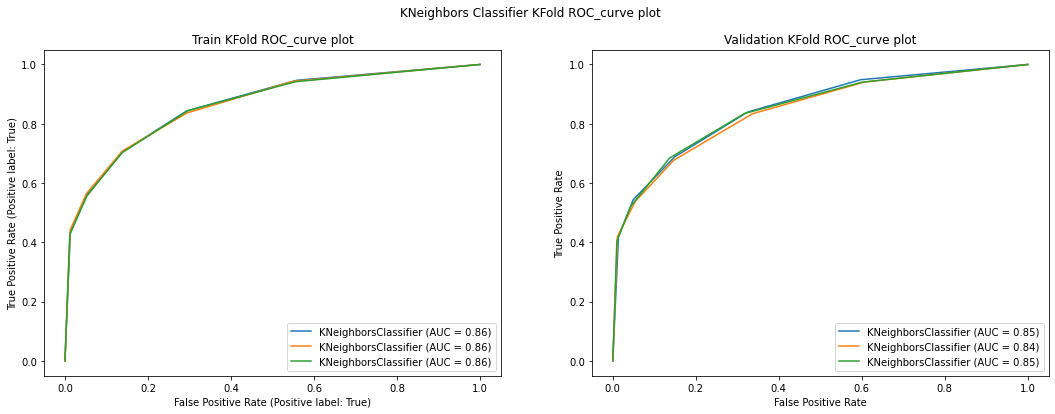

/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
No handles with labels found to put in legend.
/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


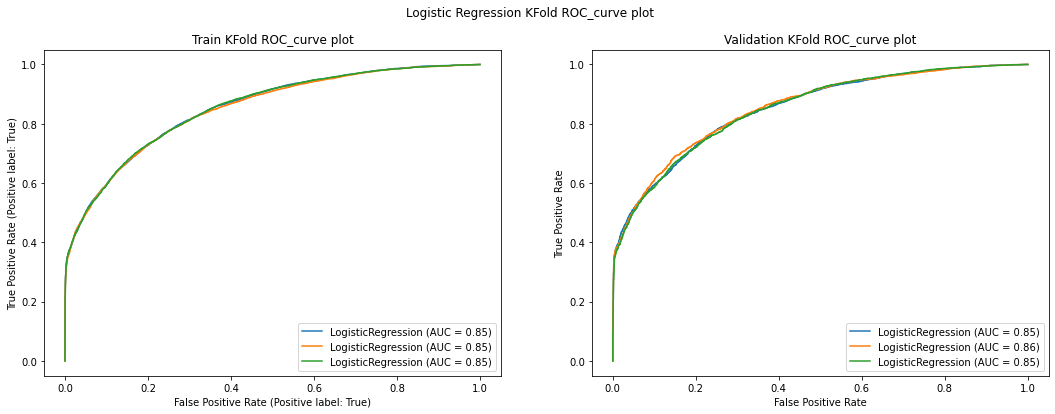

/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
No handles with labels found to put in legend.
/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


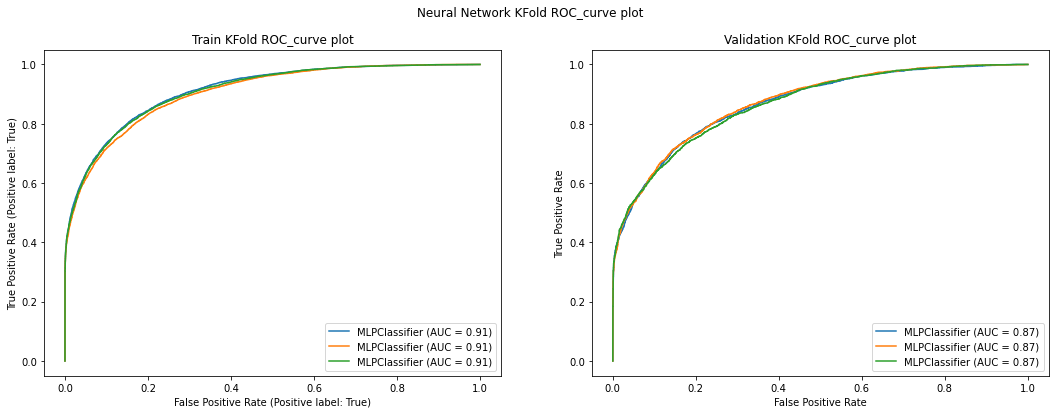

/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.
/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


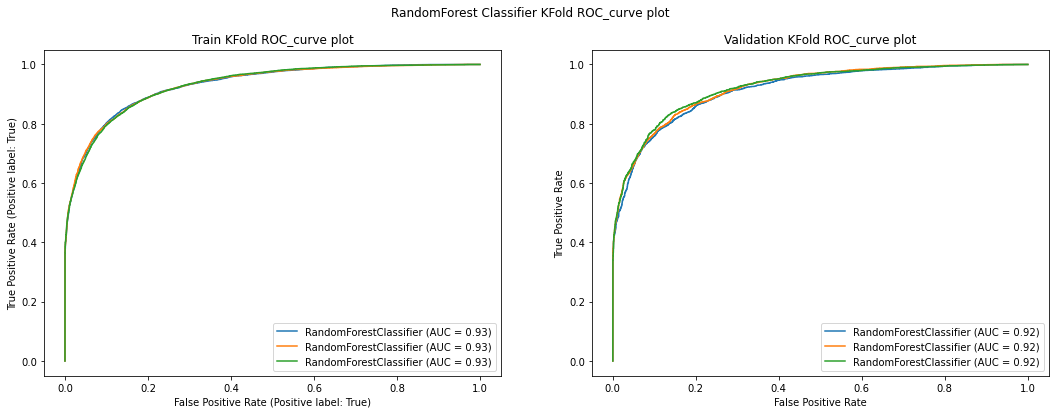

In [30]:
# creating a models list that we want to view on the ROC plot
models = [
{
    'label': 'KNeighbors Classifier',
    'model': KNeighborsClassifier( n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski'),
},
{
   'label': 'Logistic Regression',
    'model': LogisticRegression(# ---The regularization hyperparameters---
                         penalty="l1", # As shown above -l1 is abs distance(lasso),l2 is quad_distances(ridge)
                         solver='liblinear', # use this only if using 'l1' penalty, otherwise leave it as default
                         C=1, # # Inverse regularization parameter, larger C means less regularization.
                         # ---The Optimization parameters---
                         tol=0.0001, # Stopping critiria
                         max_iter=50) # For optimization algorithm, the algorithm solves it with iterations.
},
{ 'label': "Neural Network",
  'model': MLPClassifier(activation= 'logistic',
                   batch_size= 15,
                   hidden_layer_sizes= (50, 50),
                   learning_rate_init= 0.01,
                   max_iter= 500)
},
{ 'label': 'RandomForest Classifier',
  'model':  RandomForestClassifier(bootstrap= True,
              max_depth= 100,
              max_features= 3,
              min_samples_leaf= 3,
              min_samples_split= 8,
              n_estimators= 1000)
    
}
]


""" Below iterate through the models list and create the roc_curve for training data
and than Kfold on the validation data.
this way we can check if our model is over fitting and make extra safe masures,
shuffling 3 diffrent samples of data (using Kfold k=3)."""

for m in tqdm(models):
    model = m['model'] # select the model
    model_name = m['label']
    
    KFold_evaluate_model(model_name, model, X_tr, y_train, X_te, y_valid)    

### we  notice:
#### 1) in the KNN model we can see almost no reduction in the test scores compared to the train score, hence we know that the model dosn't suffer from over fitting.

#### 2) in the LogisticRegression model there isn't any diffrence between the train and the test score, meaning we have no over-fitting but the model got the lowest scores.

#### 3) for the MLPClassifier there is an  insignificante difference between the train and the test scores, meaning we do not suffer from over-fitting, more-over the scores are higher than the KNN & LR models.


#### 4) RandomForestClassifier has a small difference between the train and test scores, meaning we may suffer a little bit from over-fitting  but the test score are the highest.

#### because we used kfold the data was splited into samplse so we will predict again on the chosen model using the entire data.

### after valuating the trade-offs we chose our model to be MLPClassifier making which has less probabilty to suffer from over fitting.

<img src="https://www.folio3.ai/blog/wp-content/uploads/2020/03/advantages-of-neural-networks-1-800x533.jpg" width=350>


/Users/tuvalsmac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


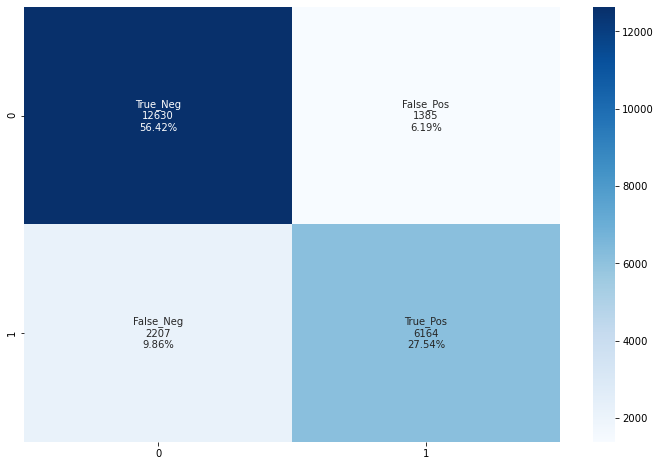

In [31]:
""" Our chosen model is MLPClassifier(), we will use all the data for one last check.
note: we tried with to run the model
with the feature reduction fun & pca func but the scores were lower."""

mlp = MLPClassifier(activation= 'logistic',
                   batch_size= 15,
                   hidden_layer_sizes= (50, 50),
                   learning_rate_init= 0.01,
                   max_iter= 500)  # Using the best parameters found with grid search

mlp.fit(X_tr[X_tr.columns], y_train)

plot_conf_mat(mlp, X_tr,y_train, X_te, y_valid)

### expaining the confusion mat regarding the model
#### TP (true positive, on the botom right) means that we predicted that the trip will be cancelled and it did.   
#### TN (true negative, on the left upperside) means that we predicted that the trip will continue as schaduald and it did.   
#### FP (false positive, uper right corner also known as type 1 error) means that we predicted that the trip will be cancelled but it didn't.
#### FN (false negative, left botom left side also known as type 2 error) means that the trip will be as planed but it was cancelled.

Text(0.5, 1.0, 'MLPClassifier final Train roc_curve score')

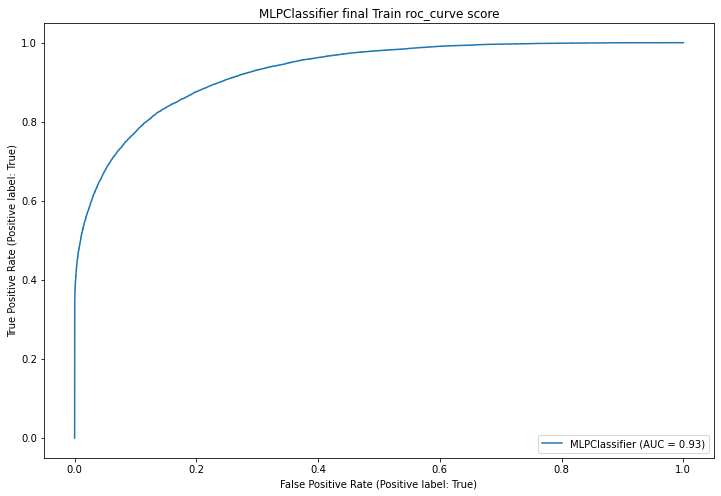

In [32]:
plot_roc_curve(mlp, X_tr[X_tr.columns], y_train)
plt.title("MLPClassifier final Train roc_curve score")

Text(0.5, 1.0, 'MLPClassifier final Validation roc_curve score')

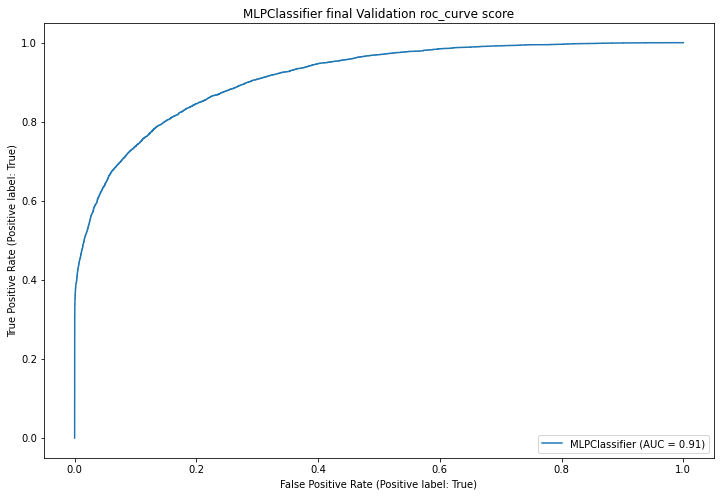

In [33]:
plot_roc_curve(mlp, X_te[X_te.columns], y_valid)
plt.title("MLPClassifier final Validation roc_curve score")

### as we can see the results of the train and test scores are very close 0.93,0.92 respectively hence we asume that there our model isn't over fitted.
#### note: this is the main reason we chose the MLP model over RandomForest who had a little bit higher score but also a higher diffrence between the tests scores which we thout might lead to over fitting. 

## Final Stage Test prediction

In [34]:
#predicting on the data Test labels.

test_cancel_predict = mlp.predict_proba(X_test)[:,1] 
#[:,1] gives us the probabilities to predict "1" meaning cancelation.

test_predict = pd.DataFrame(test_cancel_predict) 
col_name = ["cancel_proba"]
test_predict.to_csv("Submission_group_8.csv",header= col_name )

# Bon Voyage

<tr><td><img src="https://tailoredspain.com/wp-content/uploads/2015/03/traveling.png" width=700></td><td>
